## MBHB tutorial: how to start analysing Sangria data 

This tutorial covers:

  * Reading the Sangria data
  * Producing MBHB signal based on the parameters in the training dataset
  * Computation of likelihood/SNR
  * Example of the search results

Requirements for running this notebook
   * LDC: https://gitlab.in2p3.fr/LISA/LDC
   * lisabeta (ask Sylvain Marsat)
   
**Acknowledgement: Fast waveform generation and search are based on "lisabeta" package developped by Sylvain Marsat**


Including modules 

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
from scipy.interpolate import InterpolatedUnivariateSpline as spline
import copy
from tqdm import tqdm as tqdm
import xarray as xr
from astropy import units as u
import pandas as pd
import h5py

from ldc.common.constants import ldc_cosmo as cosmo
import lisaconstants as constants
from ldc.lisa.orbits import Orbits
from ldc.lisa.projection import ProjectedStrain

import lisabeta
import lisabeta.pyconstants as pyconstants
import lisabeta.tools.pytools as pytools
import lisabeta.tools.pyspline as pyspline
import lisabeta.tools.pyoverlap as pyoverlap
import lisabeta.lisa.pyresponse as pyresponse
import lisabeta.lisa.lisatools as lisatools
import lisabeta.lisa.snrtools as snrtools
import lisabeta.lisa.lisa as lisa
import lisabeta.lisa.lisa_fisher as lisa_fisher
import lisabeta.inference.inference as inference
import lisabeta.utils.plotutils as plotutils
import lisabeta.waveforms.bbh.pyIMRPhenomD as pyIMRPhenomD

plt.style.use(['seaborn-ticks','seaborn-deep'])
# %pylab inline
mpl.rcParams.update({'font.size': 16})
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (12,7)
%load_ext autoreload
%autoreload 2

## Reading the data and transforming to frequency domain

In [2]:
from ldc.common.series import TimeSeries, FrequencySeries, TDI
from ldc.common.tools import compute_tdi_snr, window

sangria_fn = "LDC2_sangria_training_v2.h5"
tdi_ts = TDI.load(sangria_fn, name="obs/tdi")
dt = tdi_ts["X"].attrs["dt"]

# Build frequencyseries object for X,Y,Z
tdi_fs = TDI(dict([(k,tdi_ts[k].ts.fft(win=window)) for k in ["X", "Y", "Z"]]))

In [3]:
 tdi_fs

<xarray.TDI>
Dimensions:  (f: 3153601)
Coordinates:
  * f        (f) float64 0.0 3.171e-08 6.342e-08 9.513e-08 ... 0.1 0.1 0.1 0.1
Data variables:
    X        (f) complex128 (-1.6591974871462708e-13+0j) ... (-2.664627478753...
    Y        (f) complex128 (-4.060020028634799e-14+0j) ... (2.15612738874411...
    Z        (f) complex128 (2.0651994898938783e-13+0j) ... (6.42228463973767...

### Get parameters of MBHBs in the training dataset

In [4]:
import ldc.io.hdf5 as hdfio
mbhb, units = hdfio.load_array(sangria_fn, name="sky/mbhb/cat")
pd.DataFrame(mbhb)

,EclipticLatitude,EclipticLongitude,PolarAngleOfSpin1,PolarAngleOfSpin2,Spin1,Spin2,Mass1,Mass2,CoalescenceTime,PhaseAtCoalescence,InitialPolarAngleL,InitialAzimuthalAngleL,Redshift,Distance,ObservationDuration,Cadence
0,-0.564102,0.610927,0.908972,1.181699,0.972661,0.972862,1.015522e+06,7.968491e+05,4.800021e+06,4.275929,2.577539,4.094550,2.18186,17758.367941,3.155815e+07,3.0
1,-1.081082,4.052963,2.354232,1.689765,0.742128,0.989247,4.956676e+06,4.067167e+06,8.746488e+06,3.783309,0.963586,3.636925,6.17688,61097.116076,3.155815e+07,3.0
2,0.636028,0.779159,2.332027,2.065443,0.574122,0.592671,1.773563e+06,1.083356e+06,1.116784e+07,2.311127,0.232802,3.798411,6.03496,59472.237592,3.155815e+07,3.0
3,-0.878570,4.549720,2.068669,1.097989,0.942824,0.870789,9.159926e+05,7.017527e+05,1.125857e+07,1.150360,1.899782,5.829771,1.10396,7705.852640,3.155815e+07,3.0
4,-0.303004,1.292518,1.203136,2.097304,0.747377,0.838800,1.323277e+06,6.124855e+05,1.152694e+07,1.220197,2.691982,1.808398,1.73941,13470.983559,3.155815e+07,3.0
5,0.147296,5.986230,2.434152,1.926613,0.745574,0.546848,2.830218e+06,2.322253e+06,1.197096e+07,4.111379,1.131250,4.319761,5.50770,53474.693790,3.155815e+07,3.0
6,-0.987304,3.886726,2.594339,1.719446,0.829141,0.972219,3.204750e+06,3.056613e+06,1.361711e+07,3.628682,2.050928,1.084370,2.87966,24829.137775,3.155815e+07,3.0
7,0.917031,3.584892,1.665850,2.092903,0.988778,0.975945,1.856420e+06,1.801541e+06,1.653219e+07,1.866057,1.410068,0.527915,4.57261,43010.925050,3.155815e+07,3.0
8,0.835250,3.257316,2.362671,1.539846,0.833674,0.981901,3.983915e+06,2.049535e+06,1.724516e+07,1.578620,2.323179,3.643228,3.34910,29747.551597,3.155815e+07,3.0
9,-0.521369,3.085541,2.582941,2.200156,0.825883,0.811360,3.128823e+06,2.640346e+06,1.860576e+07,3.425317,2.604701,1.670016,7.21026,73048.167218,3.155815e+07,3.0


### Use the very first source and generate using (very) fast route

Casting parameters into a different form

In [20]:
from ldc.common import tools
from ldc.waveform.lisabeta import FastBHB

s_index = 0 # Look at 1st source
tmax = tdi_ts["X"].t[-1].values+dt
pMBHB = dict(zip(mbhb.dtype.names, mbhb[s_index]))
FBH = FastBHB("MBHB", T=tmax, delta_t=dt, approx="IMRPhenomD")
pMBHB = FBH.rename_as_lisabeta(pMBHB)

# Compute mass ratio and chirp mass
m1 = pMBHB['m1']
m2 = pMBHB['m2']
q = m1/m2
Mc = (m1+m2)*(q/(1+q)**2)**0.6

src0 = pMBHB.copy()
src0.pop("m1"); src0.pop("m2")
src0["Mchirp"] = Mc
src0["q"] = q
src0['psi'] += np.pi
src0['phi'] -= np.pi 

params_range = {
    "Mc":  [5000.0, 500000000.0],
    "q": [1, 30],
    "chi1": [-1, 1],
    "chi2": [-1, 1],
    "Deltat": [-10000, 10000],
    "dist": [500.0, 1000000.0],
    "inc": [0., np.pi],
    "phi": [-np.pi, np.pi],
    "lambda": [-np.pi, np.pi], 
    "beta": [-np.pi/2, np.pi/2],
    "psi": [0., np.pi]
}

# auxiliary parameters
waveform_params_smbh = {
    "minf": 1e-5,
    "maxf": 0.1,
    "t0": 0.0,
    "timetomerger_max": 1.0,
    "fend": None,
    "tmin": None,
    "tmax": 1.0,
    "phiref": 0.0,
    "fref_for_phiref": 0.0,
    "tref": 0.0,
    "fref_for_tref": 0.0,
    "force_phiref_fref": True,
    "toffset": 0.0,
    "modes": None,
    "TDI": "TDIAET",
    "acc": 1e-4,
    "order_fresnel_stencil": 0,
    "approximant": "IMRPhenomD",
    "LISAconst": "Proposal",
    "responseapprox": "full",
    "frozenLISA": False,
    "TDIrescaled": False,
    "LISAnoise": {
        "InstrumentalNoise": "SciRDv1",
        "WDbackground": True,
        "WDduration" : 1.0,
        "lowf_add_pm_noise_f0": 0.0,
        "lowf_add_pm_noise_alpha": 2.0
    }
}

print(src0)

{'beta': -0.5641023936335077, 'lambda': 0.6109268516130327, 'chi1': 0.597755394865021, 'chi2': 0.36905807298613247, 'Deltat': 4800021.15572853, 'phi': 1.134336655106261, 'dist': 17758.367941273442, 'psi': 1.7511448636230775, 'inc': 1.5970175301911231, 'Mchirp': 781969.6939241044, 'q': 1.2744225048415756}


### Generate waveform

In [6]:
tdisignal = lisa.GenerateLISATDISignal_SMBH(src0, **waveform_params_smbh)

tdi = tdisignal['tdi'] 
print ('content', tdi.keys())
print (tdi[(2,2)].keys())
print ('Using ', len(tdi[(2,2)]['freq']), 'frequencies' )
print ('total SNR of the source', tdisignal['SNR'])

content dict_keys(['modes', (2, 2)])
dict_keys(['freq', 'phase', 'amp_real_chan1', 'amp_imag_chan1', 'amp_real_chan2', 'amp_imag_chan2', 'amp_real_chan3', 'amp_imag_chan3'])
Using  268 frequencies
total SNR of the source 1561.4334578924027


The waveform is decomposed in several parts:
$$ TDI_A(f) = \mathcal{T}_A(t,f) A(f) e^{i\Psi(f)} $$ 
    
   * Response:  $\mathcal{T}_A(t,f)$ is a complax function
   * Phase in frequency domain $\Psi(f)$
    
Both are slow varying functions. The overall amplitude is $\mathcal{A} =  \mathcal{T}_A(t,f) A(f)$



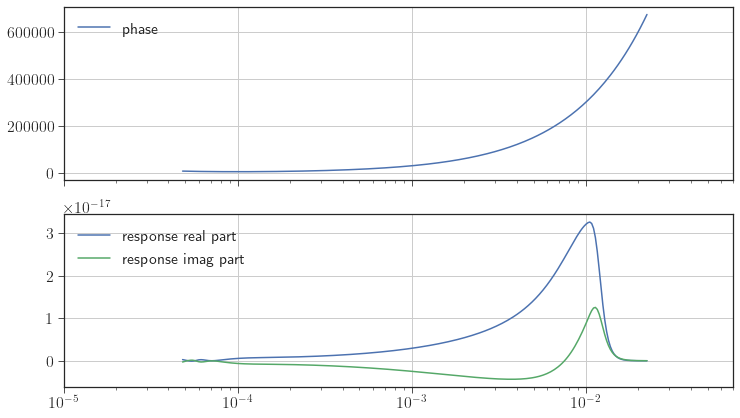

In [11]:
mbh_lb = tdi[(2,2)]

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].semilogx(mbh_lb['freq'], mbh_lb['phase'], label="phase")
ax[0].legend(loc = 'upper left')
ax[1].semilogx(mbh_lb['freq'], mbh_lb['amp_real_chan1'], label='response real part')
ax[1].semilogx(mbh_lb['freq'], mbh_lb['amp_imag_chan1'], label='response imag part')
ax[1].legend(loc = 'upper left')
plt.axis([1e-5, 7.e-2, None, None])
plt.show()

### Compute likelihood/SNR in conventional way


To compute likelihood/SNR we need to compute inner product
$$ (d | X) = 4 \Re \int \frac{\tilde{d}(f) \tilde{X}^*(f)}{S_n(f)}\, df$$

which is approximated as a sum: 
$$
\sum_i \frac{\tilde{d}(f_i) \tilde{X}^*(f_i)}{S_n(f_i)} \Delta f
$$
where $\tilde{d}(f)$ is data in freq. domain and $\tilde{X}(f)$ is our waveform (template).


So we need to interpolate the waveform at the fourier frequencies of the data

705023


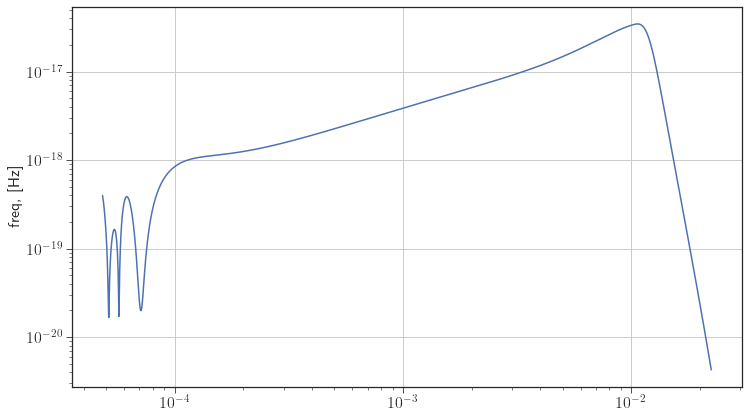

In [19]:
# frequency band of the signal
fmin = mbh_lb['freq'][0]
fmax = mbh_lb['freq'][-1]
tdi_sel = tdi_fs.sel(f=slice(fmin, fmax))
fr_sig = tdi_sel.f.values
print (len(fr_sig))

# constructing spline 
splPh = spline(mbh_lb['freq'], mbh_lb['phase'])
splAr = spline(mbh_lb['freq'], mbh_lb['amp_real_chan1'])
splAi = spline(mbh_lb['freq'], mbh_lb['amp_imag_chan1'])

# constructing signal at each Fouriner freq. 
Afull = np.conjugate((splAr(fr_sig) + 1.j*splAi(fr_sig))*np.exp(1j*splPh(fr_sig)))

# construct A-TDI for the data
Adata = (tdi_sel["Z"].values - tdi_sel["X"].values)/np.sqrt(2.0)

plt.loglog(fr_sig, np.abs(Afull))
plt.ylabel("A-TDI signal")
plt.ylabel("freq, [Hz]")
plt.show()


### Get analytic noise psd and overplot 

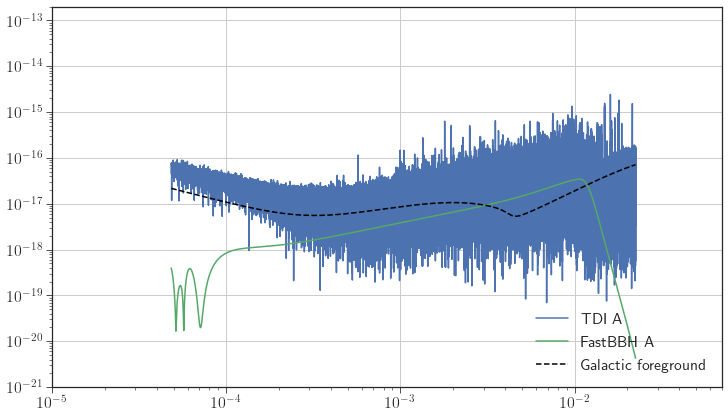

In [23]:
from ldc.lisa.noise import AnalyticNoise, get_noise_model
import ldc.io.hdf5 as hdfio 

df = 1.0/tmax
cfg = hdfio.load_config(sangria_fn, "obs/config")
acc = cfg['accnoise']**2
oms = (cfg['backlinknoise'] + cfg['readoutnoise'])**2

Nmodel_g = AnalyticNoise(fr_sig, model="sangria-training", oms=oms, acc=acc, wd=1)
Npsd_gal = Nmodel_g.psd(option='A', tdi2=False)

plt.loglog(fr_sig, np.abs(Adata), label="TDI A")
plt.loglog(fr_sig,  np.abs(Afull), label='FastBBH A')
plt.loglog(Nmodel_g.freq, np.sqrt(0.5*Npsd_gal/df), 'k--', label="Galactic foreground")
plt.axis([1e-5, 7.e-2, 1e-21, 2e-13])
plt.legend(loc='lower right')
plt.show()

log-likelihood is given (up to a constant) as
$$ -\frac1{2} (d - A | d - A) = -\frac1{2} (d|d) + (d|A) - \frac1{2} (A|A) \to (d|A(\theta)) - \frac1{2} (A|A)(\theta)$$

The SNR is defined as $\sqrt{(A|A)}$ we call it optimal SNR, and we define measured or matched filter SNR: 
$\sqrt{(d|A)}$, the matched filter SNR averaged over the noise realizations is equal to optimal SNR 

In [24]:
def compute_likelihood(D, h, Sn, df):
    SN_m = 4.0*df* np.sum( np.real(D*np.conjugate(h))/Sn )
    XX = 4.0*df*np.sum( np.abs(h)**2/Sn )
    loglik = SN_m - 0.5*XX
    return (SN_m, XX, loglik)

Npsd_galA = Nmodel_g.psd(option='A', tdi2=False)

In [25]:
SN2, XX, loglik =  compute_likelihood(Afull, Afull, Npsd_galA, df)
print (f'for A-TDI: the optimal SNR  {np.sqrt(XX)} and likelihood is {loglik}')

for A-TDI: the optimal SNR  1508.0332430887852 and likelihood is 1137082.1311304397


In [26]:
SN2, XX, loglik =  compute_likelihood(Adata, Afull, Npsd_galA, df)
print (f'for A-TDI: the matched filer SNR  {np.sqrt(SN2)} and likelihood is {loglik}')
# print (SN2, XX, np.sqrt(SN2), np.sqrt(XX))

for A-TDI: the matched filer SNR  1506.7646003908533 and likelihood is 1133257.4298605681


### Benchmarking

(Very) Fast SNR computation: noiseless, uses sparse (non-uniform) frequencies to generate the waveform and evaluate the SNR/likelihood integral  

In [27]:
import time
st = time.time()
Nit = 1000
for ii in range(Nit):
    tdisignal = lisa.GenerateLISATDISignal_SMBH(src0, **waveform_params_smbh)
en = time.time()

print (f'ellapsed {en-st}, per SNR {(en-st)/Nit}')

ellapsed 1.1669182777404785, per SNR 0.0011669182777404785


Compare to the cost for interpolation to each Fourier bin and likelihood evaluation via sum  

In [28]:
def spline_and_SNR():
    splPh = spline(mbh_lb['freq'], mbh_lb['phase'])
    splAr = spline(mbh_lb['freq'], mbh_lb['amp_real_chan1'])
    splAi = spline(mbh_lb['freq'], mbh_lb['amp_imag_chan1'])
    Afull = np.conjugate((splAr(fr_sig) + 1.j*splAi(fr_sig))*np.exp(1j*splPh(fr_sig)))
    compute_likelihood(Adata, Afull, Npsd_galA, df)
    


In [29]:
st = time.time()
Nit = 200
for ii in range(Nit):
    spline_and_SNR()

en = time.time()
print (f'ellapsed {en-st}, per SNR {(en-st)/Nit}')

ellapsed 35.077242374420166, per SNR 0.17538621187210082


## Search for MBHB

Given this significant time consumption per likelihood (need of order 1-10 mln evaluations)
we have cheated: performed "the search" on the noiseless data (high SNR approximation)

For the search we have assumed the following prior for parameters (very broad)

In [30]:
params_range = {
    "Mc":  [5000.0, 500000000.0],
    "q": [1, 30],
    "chi1": [-1, 1],
    "chi2": [-1, 1],
    "Deltat": [-10000, 10000],
    "dist": [500.0, 1000000.0],
    "inc": [0., np.pi],
    "phi": [-np.pi, np.pi],
    "lambda": [-np.pi, np.pi], 
    "beta": [-np.pi/2, np.pi/2],
    "psi": [0., np.pi]
}

We performed a run on the CNES cluster using **lisabeta** infrastructure. Used 24 cores (MPI) for 2 hours.

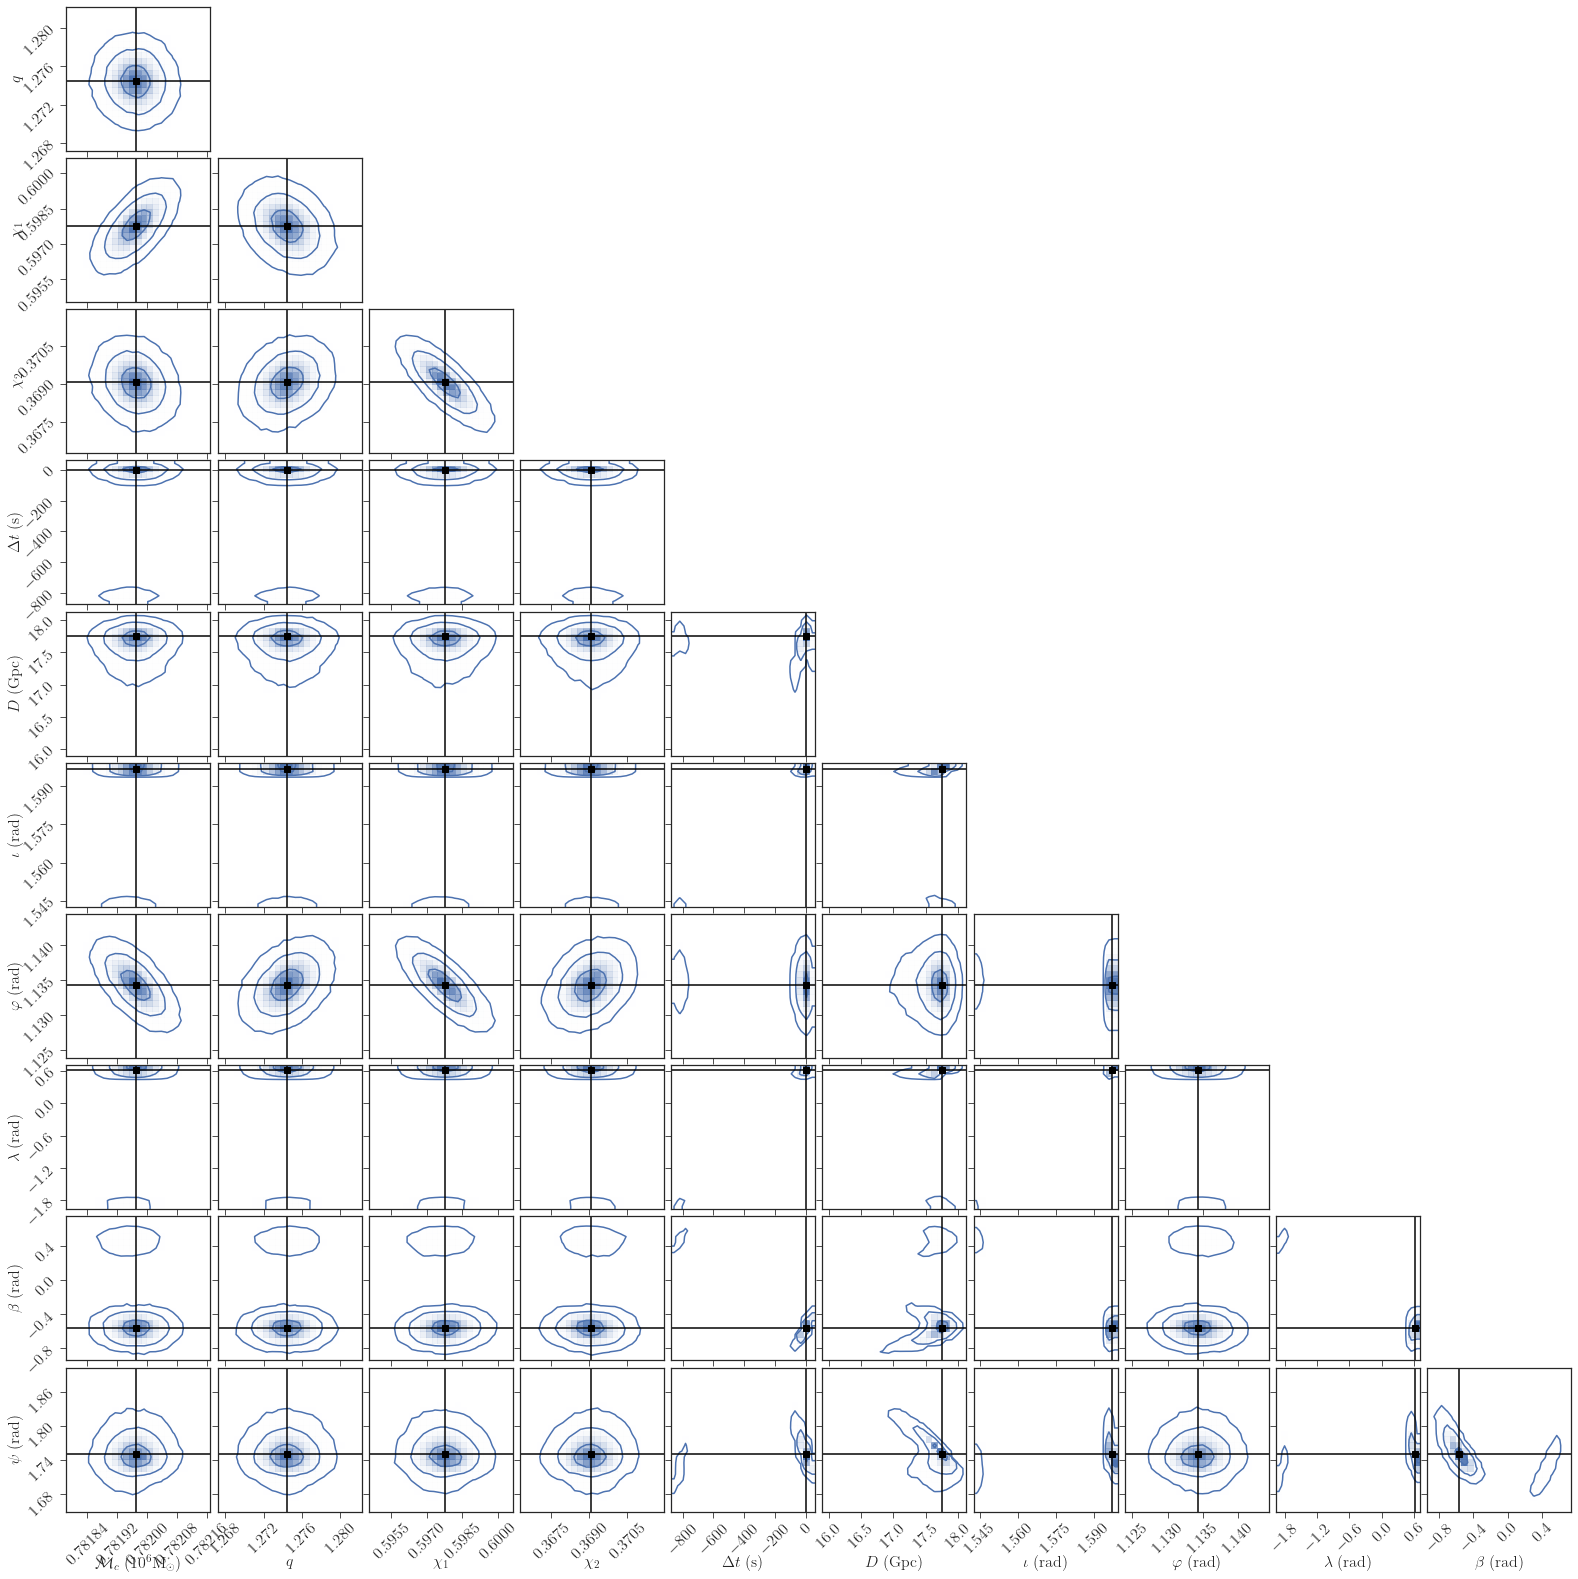

In [17]:
src_dr = './'
param_file = src_dr + 'cp_event_0.json'
poster_file = src_dr + 'results/smbh_8modes_sangria0.h5'

import lisabeta.utils.plotutils as plotutils
dat_plt1 = plotutils.load_params_posterior_lisa_smbh(param_file, poster_file, \
                                                     format='multiemcee', load_fisher=False)

fig2 = plotutils.corner_plot(dat_plt1['injparams_SSBframe'], dat_plt1['post'], add_posteriors=[], output=False, \
                            output_dir=None, output_file=None, histograms=True, fisher=False, fishercov=None, Lframe=False, \
                            params=['Mchirp', 'q', 'chi1', 'chi2', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi'], \
#                             params=['Mchirp', 'q', 'chiPN', 'chim', 'fstart', 'dist', 'inc', 'lambda', 'beta', 'Omega_AGN', 'Rcostheta_AGN', 'Rsintheta_AGN', 'phi_AGN'], \
                            color=plotutils.plotpalette[0], cov_color='k', add_colors=[plotutils.plotpalette[1]], show_truths=True, truth_color='k', bins=25, show_histograms=False, \
                            plot_datapoints=False)
plt.show()

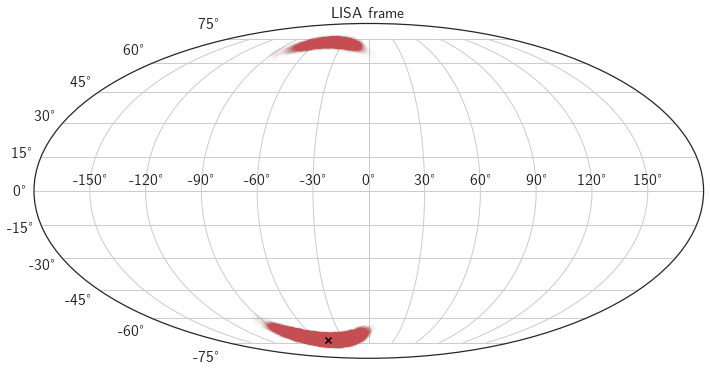

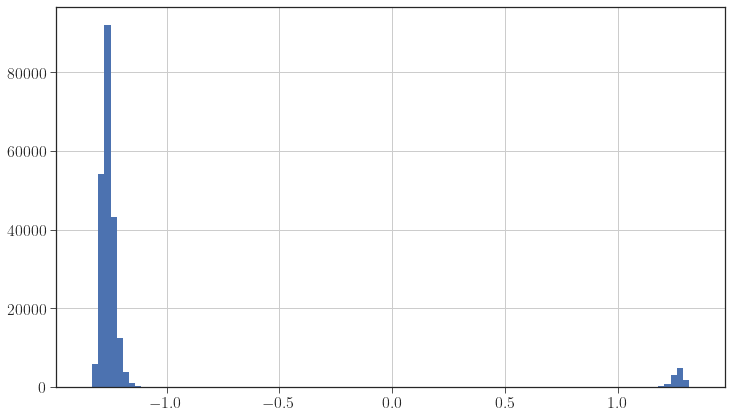

In [24]:
plotpal = ["#4C72B0", "#C44E52", "#CCB974", "#55A868", "#8172B2", "#64B5CD"]
lam = dat_plt1['post']['lambda']  ### long
bet = dat_plt1['post']['beta']  ### lat

tL, lamL, betL, psiL = lisa.lisatools.ConvertSSBframeParamsToLframe(src0['Deltat'], src0['lambda'], src0['beta'], 
                                                                    src0['psi'], 0.0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
ax.set_title('LISA frame')
ax.scatter(lam, bet, c=plotpal[1], alpha=0.01)
ax.scatter([lamL], [betL], c='k', marker='x')
plt.show()

plt.hist(bet, bins= 100)
plt.show()